# Exploration of Complex Topics in Deep Learning

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Train, Eval and Helper Functions
---

In [3]:
NUM_EPOCHS = 30

def train_model(model, optimizer, criterion, train_loader, test_loader, num_epochs=30, device='cpu'):
    
    # Move model to device
    model = model.to(device)
    
    # For tracking metrics
    train_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):

        #Training Phase
        model.train()
        # print(f"Epoch {epoch} in progress...")
        running_loss = 0

        for batch_idx, (X, y) in enumerate(train_loader):
            
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            output = model.forward(X)
            loss = criterion(output, y)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        #Evaluation Phase
        model.eval()

        test_loss = 0
        correct = 0
        with torch.no_grad():

            for (X,y) in test_loader:
                X, y = X.to(device), y.to(device)
                output = model.forward(X)
                test_loss += criterion(output, y).item()

                # Get the index of the max log-probability
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(y.view_as(pred)).sum().item()
                

        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        
        accuracy = 100. * correct / len(test_loader.dataset)
        test_accuracies.append(accuracy)
        
        print(f'Epoch: {epoch+1}/{num_epochs}')
        print(f'Train Loss: {avg_train_loss:.4f}')
        print(f'Test Loss: {test_loss:.4f}')
        print(f'Test Accuracy: {accuracy:.2f}%\n')
    
    return train_losses, test_losses, test_accuracies


In [4]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_pred = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model.forward(data)
            pred = output.argmax(dim=1)

            all_pred.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            
    return all_pred, all_targets

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [6]:
def plot_train_metrics(train_losses, test_losses, test_accuracies):
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy Curve')

    plt.tight_layout()
    plt.show()

In [7]:
def plot_eval_res(predictions, targets):
    
    cm = confusion_matrix(targets, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification report
    print(classification_report(targets, predictions))    


## CIFAR10 Dataset
---
Useful for more complex NN architecture testing purposes.

In [8]:
# import ssl
# import urllib.request

# # Disable SSL certificate verification
# ssl._create_default_https_context = ssl._create_unverified_context

In [9]:
# Define transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Load datasets
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

# Create data loaders
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

# Class names for reference
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

In [10]:
class Transfer_Learning(nn.Module):
    def __init__(self):
        super(Transfer_Learning, self).__init__()
        model = torchvision.models.resnet18(pretrained=True)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 10)
        self.model = model

    def forward(self, x):
        return self.model(x)


Epoch: 1/1
Train Loss: 1.0206
Test Loss: 0.7592
Test Accuracy: 74.81%



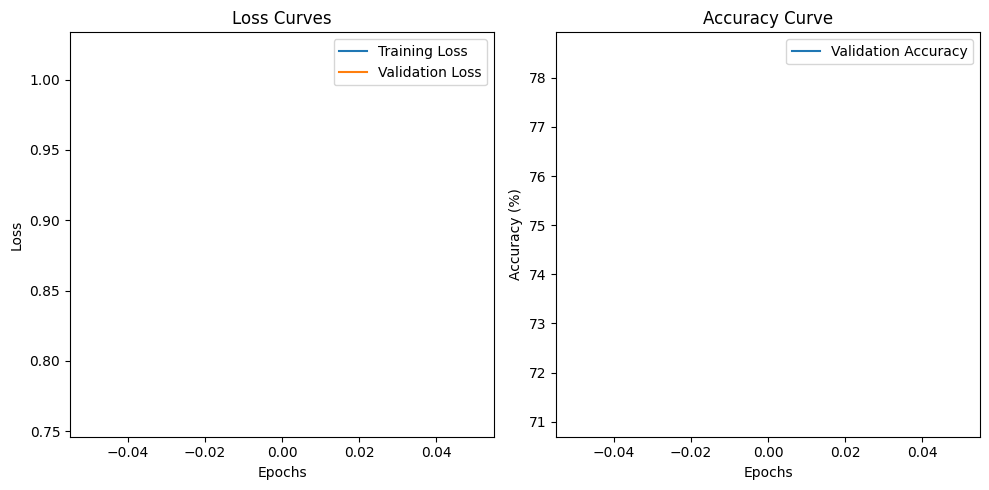

In [12]:
model_1 = Transfer_Learning()
model_1.to(device)

criterion_1 = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=0.001)

train_losses_1, test_losses_1, test_accuracies_1 = train_model(model_1, optimizer_1, criterion_1, trainloader, testloader, num_epochs=1, device=device)

plot_train_metrics(train_losses_1, test_losses_1, test_accuracies_1)


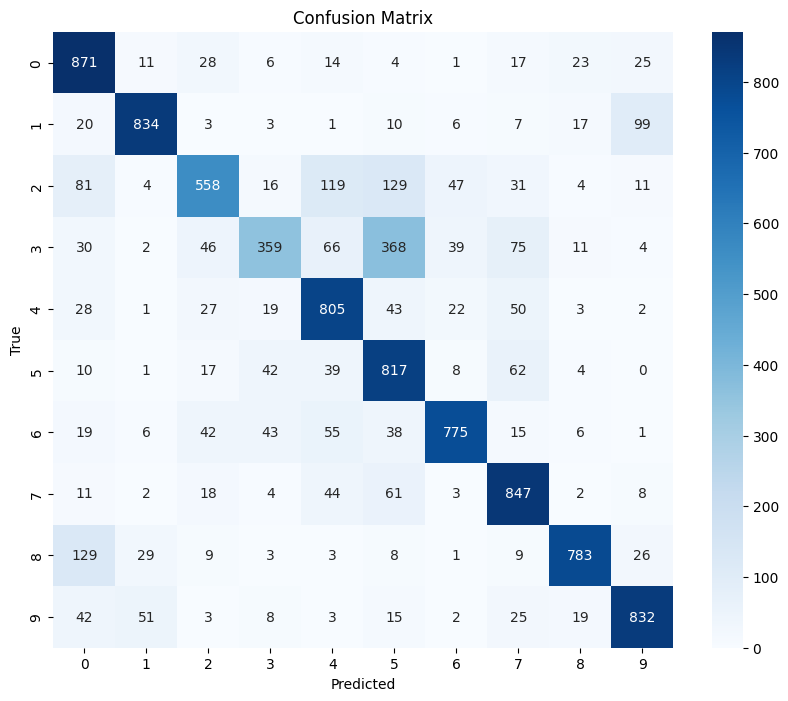

              precision    recall  f1-score   support

           0       0.70      0.87      0.78      1000
           1       0.89      0.83      0.86      1000
           2       0.74      0.56      0.64      1000
           3       0.71      0.36      0.48      1000
           4       0.70      0.81      0.75      1000
           5       0.55      0.82      0.66      1000
           6       0.86      0.78      0.81      1000
           7       0.74      0.85      0.79      1000
           8       0.90      0.78      0.84      1000
           9       0.83      0.83      0.83      1000

    accuracy                           0.75     10000
   macro avg       0.76      0.75      0.74     10000
weighted avg       0.76      0.75      0.74     10000



In [13]:
pred, targets = evaluate_model(model_1, testloader, device)
plot_eval_res(pred, targets)